# 5. Tutorial: Create iML1515 GECKO with auto-fitted turnover numbers

We developed a series of GECKO models of iML1515, with model parameters being progressively refined from one model to the next. Our initial model was based on default values, requiring minimal bespoke configuration. For our second model, we adjusted transporter-related parameters, taking into account organism- and model-specific information. For our third model, we replaced default turnover numbers with AI-predicted turnover numbers for metabolic reactions. In the fourth model, flux distributions were corrected by adjusting predicted turnover numbers of a few reactions, considering organism-specific information and experimental data of quantitative proteomics. 

In this tutorial, we extend the concept introduced in the previous tutorial to automatically fit turnover numbers to proteomics data. This fitting process will not be perfect, but the model will improve significantly with respect to predicting protein levels. One limitation of the automatic fitting process is that it can only be applied to reactions and pathways carrying flux as per our predictions. This is also the reason why we corrected the flux balance between glycolysis and PPP. 

Quantitative proteomics is a valuable source of data for determining more realistic apparent turnover numbers, as required for enzyme constraint models, by adjusting default and predicted turnover numbers. This is due to the almost complete coverage and use of standardized experimental methods in quantitative proteomics. To circumvent the pitfalls of overfitting, we intend to impose constraints on the extent of adjustment.

It should be noted, that alternative fitting procedures exist in GECKO 2.0 (Domenzain et al., 2022) for single conditions and using the PRESTO formalism (Wendering et al., 2023) across multiple growth conditions.

Peter Schubert, Heinrich-Heine University Duesseldorf, Institute for Computational Cell Biology (Prof. Dr. M. Lercher), January, 2025

## Step 1: Initial setup

In [1]:
# Required imports and model names
import os
import re
import pandas as pd
import cobra

from f2xba import XbaModel, EcModel
from f2xba import EcmOptimization, EcmResults
from f2xba import GeckoFitKcats
from f2xba.utils.mapping_utils import load_parameter_file, write_parameter_file

fba_model = 'iML1515'
baseline_model = 'iML1515_manual_adjust_GECKO'
target_model = 'iML1515_predicted_fit_GECKO'
reference_cond = 'Glucose'
        
# Create media conditions
media_grs = {'Acetate': ['ac', 0.29], 'Glycerol': ['glyc', 0.47], 'Fructose': ['fru', 0.54], 
             'L-Malate': ['mal__L', 0.55], 'Glucose': ['glc__D', 0.66], 'Glucose 6-Phosphate': ['g6p', 0.78]}
base_medium = ['ca2', 'cbl1', 'cl', 'co2', 'cobalt2', 'cu2', 'fe2', 'fe3', 'h2o', 'h', 'k', 'mg2', 
               'mn2', 'mobd', 'na1', 'nh4', 'ni2', 'o2', 'pi', 'sel', 'slnt', 'so4', 'tungs', 'zn2']
conditions = {}
exp_grs = {}
for cond, (carbon_sid, exp_gr )in media_grs.items():
    conditions[cond] = {f'EX_{sidx}_e': 1000.0 for sidx in base_medium}
    conditions[cond][f'EX_{carbon_sid}_e'] = 1000.0
    exp_grs[cond] = exp_gr
print(f'{len(conditions)} minimal media conditions created for simulation')

# Load proteomics
fname = os.path.join('data', 'Ecoli_Schmidt_proteomics.xlsx')
with pd.ExcelFile(fname) as xlsx:
    df_mpmf = pd.read_excel(xlsx, sheet_name='proteomics', index_col=0)
    print(f'{len(df_mpmf)} records of proteomics loaded from {fname}')
min_confidence_level = 43.0
df_mpmf = df_mpmf[df_mpmf['confidence'] > min_confidence_level]
print(f'{len(df_mpmf)} records with confidence level above {min_confidence_level}')

6 minimal media conditions created for simulation
2347 records of proteomics loaded from data/Ecoli_Schmidt_proteomics.xlsx
2232 records with confidence level above 43.0


## Step 2: Fit turnover values to proteomics (cobrapy)

The workflow to automatically fit turnover numbers to proteomics begins with determining the flux distribution predicted for the baseline GECKO model on the reference condition, which is glucose minimal medium.

Subsequently, the measured protein concentrations are extracted from the proteomics data. It is imperative to note that the four major outer membrane pores ('b0929', 'b2215', 'b1377', 'b0241') will be excluded from the automated fitting process to avoid interference with the turnover number adjustments performed in the 2nd tutorial. Additionally, the protein measurement for b2400\gltX, which catalyzes glutamyl-tRNA charging, is excluded. In FBA and GECKO, this is used for the synthesis of biomass components protoheme (M_pheme_c) and siroheme (M_sheme_c), but not for tRNA charging.

Finally, we perform the automated fit process using an instance of `GeckoFitKcats` to generate updated turnover numbers for the target model. The fitting process adjusts the coupling factors through updated turnover numbers to align predicted flux distribution to measured protein levels. In a simple example, if predicted flux through a given reaction predicts a protein concentration that is double of the measured level, the fitting process would double the respective turnover number. The fitting process adjusts turnover numbers for reactions that carry flux, and it can switch flux between iso-reactions and consider promiscuous enzymes that catalyze more than one reaction. To avoid overfitting, a maximum scaling factor can be provided. Finally, all turnover numbers will be rescaled for a given target enzyme saturation.

### 2.1 flux distribution in baseline model

The predicted flux distribution is determined, and it is used as a reference for the fitting task.

In [2]:
# Load GECKO model and optimize for reference condition
fname = os.path.join('SBML_models', f'{baseline_model}.xml')
ecm = cobra.io.read_sbml_model(fname)
total_protein = ecm.reactions.get_by_id('V_PC_total').upper_bound

eo = EcmOptimization(fname, ecm)
sigma = eo.avg_enz_saturation
print(f'total modeled protein: {total_protein:.2f} mg/gDW, enzyme saturation level: {sigma}')

# Calculate GECKO solution for given condition
ecm.medium = conditions[reference_cond]
solution = ecm.optimize()
gr = solution.objective_value
print(f'{reference_cond}: growth rate {gr:.3f} h-1 ({solution.status})')

Set parameter Username
Set parameter LicenseID to value 2731209
Academic license - for non-commercial use only - expires 2026-10-31
SBML model loaded by sbmlxdf: SBML_models/iML1515_manual_adjust_GECKO.xml (Thu Feb 12 15:21:50 2026)
total modeled protein: 306.59 mg/gDW, enzyme saturation level: 0.56
Glucose: growth rate 0.661 h-1 (optimal)


### 2.2 measured protein concentrations

The protein concentrations, which have been measured, must be collected so that the turnover numbers can be adjusted. It is important to note that certain proteins have been selected and are therefore excluded from this process.

In [3]:
# Select proteins for the automatic fit
excluded_loci = {'b0929', 'b2215', 'b1377', 'b0241', 'b2400'}
measured_mpmfs = {} 
excluded_mpmfs = {} 
for locus, mpmf in df_mpmf[reference_cond].items():
    if locus in eo.locus2uid:
        if locus not in excluded_loci:
            measured_mpmfs[locus] = mpmf        
        else:
            excluded_mpmfs[locus] = mpmf

print(f'{len(measured_mpmfs):4d} proteins measured with total of {sum(measured_mpmfs.values()):5.1f} mg/gP')
print(f'{len(excluded_mpmfs):4d} proteins excluded with total of {sum(excluded_mpmfs.values()):5.1f} mg/gP')

 996 proteins measured with total of 497.8 mg/gP
   3 proteins excluded with total of  16.6 mg/gP


### 2.3 fit turnover numbers to proteomics

The automated fitting task is performed by the class `GeckoGitKcats`. During instantiation, a reference to the instance of `EcmOptimization` and the turnover numbers in the baseline model are provided. Subsequently, `gfk.process_data()` is called with the flux distribution for the reference condition and the expected protein concentrations. Finally, the function `gfk.update_kcats()` is invoked to adjust the turnover numbers, taking into account a constraint on the maximum scaling (`max_scale_factor`)  and the anticipated target enzyme saturation (`target_sat`). A maximum scaling factor of 100.0 would allow turnover numbers to be adjusted within a range of \[1/100.0 … 100.0\] $\cdot$ original value. Reactions for which the adjustment of turnover numbers was not possible due to the maximum scaling constraint are returned in the dictionary `exceeding_max_scale`. This information can be utilized to enhance the model further by adjusting pertinent model parameters.

In accordance with the GECKO optimization problem, a distinction is made between active reactions, those carrying flux, and inactive reactions. Consequently, the total modeled proteome is partitioned between the active proteome, the set of proteins required to catalyze active reactions, and the inactive proteome. The inactive proteome has a total predicted concentration of zero, while the total available protein is divided between the proteins in the active proteome. Subsequently, the value of the total available protein can be adjusted to be equal to the sum of the measured proteins of the active proteome (`tot_fitted_mpmf`).

In [4]:
# Automatically fit kcat values to proteomics
target_enz_sat = 0.5
orig_kcats_fname = os.path.join('data', f'{baseline_model}_kcats.xlsx')
fitted_kcats_fname = os.path.join('data', f'{target_model}_kcats.xlsx')

gfk = GeckoFitKcats(eo, orig_kcats_fname)

tot_fitted_mpmf = gfk.process_data(solution.fluxes, measured_mpmfs)
exceeding_max_scale = gfk.update_kcats(fitted_kcats_fname, target_sat=target_enz_sat, max_scale_factor=100.0)

5357 enzyme catalyzed iso-reactions (2221 reactions, 1494 proteins)
 394 active catalyzed reactions with total protein of 537.9 mg/gP (based on GECKO simulation)
 417 proteins potentially involved in active reactions
 352 active catalyzed reactions using total protein of 356.7 mg/gP (based on proteomics)
  42 active catalyzed reactions have no measured proteins provided
5357 original kcat records loaded from data/iML1515_manual_adjust_GECKO_kcats.xlsx
 584 kcat records fitted. Scale factor range [0.0101105, 110.0]
  24 (net) reactions would exceed the maximum scaling factor of 100.0 and will not be scaled
fitted kcats exported to data/iML1515_predicted_fit_GECKO_kcats.xlsx


## Step 3: Create GECKO model with fitted parameters

The XBA and ECM configuration files are updated. Adjustments are made to the total available protein in the ECM parameter file. Thereafter, the target GECKO model is created.

In [5]:
# Create updated XBA parameter file
xba_params = load_parameter_file(os.path.join('data', f'{baseline_model}_xba_parameters.xlsx'))
xba_params['general'].at['kcats_fname', 'value'] = os.path.join('data', f'{target_model}_kcats.xlsx')
write_parameter_file(os.path.join('data', f'{target_model}_xba_parameters.xlsx'), xba_params)

# Create updated ECM parameter file
ecm_params = load_parameter_file(os.path.join('data', f'{baseline_model}_ecm_parameters.xlsx'),['general'])
fitted_pmf = (tot_fitted_mpmf + sum(excluded_mpmfs.values()))/1000.0
ecm_params['general'].at['pm2totpm_val_or_paxdb', 'value'] = fitted_pmf
ecm_params['general'].at['avg_enz_sat', 'value'] = target_enz_sat
write_parameter_file(os.path.join('data', f'{target_model}_ecm_parameters.xlsx'), ecm_params)

3 table(s) with parameters loaded from data/iML1515_manual_adjust_GECKO_xba_parameters.xlsx (Thu Feb 12 15:21:28 2026)
3 table(s) with parameters written to data/iML1515_predicted_fit_GECKO_xba_parameters.xlsx
1 table(s) with parameters loaded from data/iML1515_manual_adjust_GECKO_ecm_parameters.xlsx (Thu Feb 12 15:21:28 2026)
1 table(s) with parameters written to data/iML1515_predicted_fit_GECKO_ecm_parameters.xlsx


In [6]:
# Create new GECKO model
xba_model = XbaModel(os.path.join('SBML_models', f'{fba_model}.xml'))
xba_model.configure(os.path.join('data', f'{target_model}_xba_parameters.xlsx'))
ec_model = EcModel(xba_model)
ec_model.configure(os.path.join('data', f'{target_model}_ecm_parameters.xlsx'))
ec_model.export(os.path.join('SBML_models', f'{target_model}.xml'))

loading: SBML_models/iML1515.xml (last modified: Thu Dec  5 10:03:46 2024)
3 table(s) with parameters loaded from data/iML1515_predicted_fit_GECKO_xba_parameters.xlsx (Thu Feb 12 15:25:00 2026)
  22 gene product(s) removed from reactions (1494 gene products remaining)
   2 attributes on reaction instances updated
3 reactions with atom imbalances, e.g. [R_PUACGAMS, R_BIOMASS_Ec_iML1515_core_75p37M, R_BIOMASS_Ec_iML1515_WT_75p37M, ...], check XbaModel.atom_imbalances.
2 reactions with charge imbalances, e.g. [R_BIOMASS_Ec_iML1515_core_75p37M, R_BIOMASS_Ec_iML1515_WT_75p37M, ...], check XbaModel.charge_imbalances.
extracting UniProt protein data from data/uniprot_organism_83333.tsv
1494 proteins created
1203 enzymes added with default stoichiometry
1 table(s) with parameters loaded from data/iML1515_enzyme_composition_updated.xlsx (Thu Feb 12 15:17:11 2026)
1203 enzyme compositions updated from data/iML1515_enzyme_composition_updated.xlsx
2221 reactions catalyzed by 1203 enzymes
default k

True

---
---
## Step 4: Load and optimize GECKO model (cobrapy)

In [7]:
# Load model using COBRApy
fname = os.path.join('SBML_models', f'{target_model}.xml')
ecm = cobra.io.read_sbml_model(fname)
total_protein = ecm.reactions.get_by_id('V_PC_total').upper_bound

eo = EcmOptimization(fname, ecm)
sigma = eo.avg_enz_saturation
all_genes = set(eo.m_dict['fbcGeneProducts']['label'].values)
tx_genes, metab_genes = eo.get_tx_metab_genes()
print(f'total modeled protein: {total_protein:.2f} mg/gDW, average saturation level: {sigma}')
print(f'{len(all_genes)} genes: ({len(tx_genes)}) transporter, ({len(metab_genes)}) metabolic')

SBML model loaded by sbmlxdf: SBML_models/iML1515_predicted_fit_GECKO.xml (Thu Feb 12 15:25:22 2026)
total modeled protein: 212.80 mg/gDW, average saturation level: 0.5
1494 genes: (492) transporter, (1002) metabolic


Acetate                  : pred gr: 0.341 h-1 vs. exp 0.290, diff:  0.051
Glycerol                 : pred gr: 0.540 h-1 vs. exp 0.470, diff:  0.070
Fructose                 : pred gr: 0.544 h-1 vs. exp 0.540, diff:  0.004
L-Malate                 : pred gr: 0.526 h-1 vs. exp 0.550, diff: -0.024
Glucose                  : pred gr: 0.613 h-1 vs. exp 0.660, diff: -0.047
Glucose 6-Phosphate      : pred gr: 0.608 h-1 vs. exp 0.780, diff: -0.172


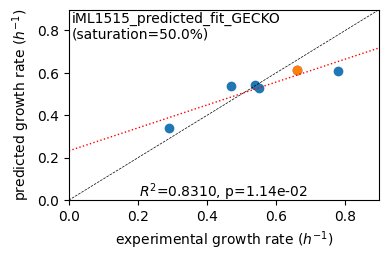

Protein mass fractions:
Acetate                  : r² = 0.2511, p = 1.25e-64 ( 999 proteins lin scale)
Glycerol                 : r² = 0.2292, p = 2.26e-58 ( 999 proteins lin scale)
Fructose                 : r² = 0.6175, p = 2.71e-210 ( 999 proteins lin scale)
Glucose                  : r² = 0.8699, p = 0.00e+00 ( 999 proteins lin scale)
Acetate                  : r² = 0.4562, p = 2.21e-42 ( 308 proteins log scale)
Glycerol                 : r² = 0.4894, p = 5.06e-47 ( 311 proteins log scale)
Fructose                 : r² = 0.5298, p = 4.40e-51 ( 302 proteins log scale)
Glucose                  : r² = 0.5498, p = 7.85e-56 ( 313 proteins log scale)

condition: Glucose
1494 proteins in model with total predicted mass fraction of 373.3 mg/gP
      999 have been measured with mpmf of  514.4 mg/gP vs. 331.8 mg/gP predicted
           762 metabolic proteins measured 414.0 mg/gP vs. 280.5 mg/gP predicted
           237 transport proteins measured 100.4 mg/gP vs.  51.3 mg/gP predicted
      4

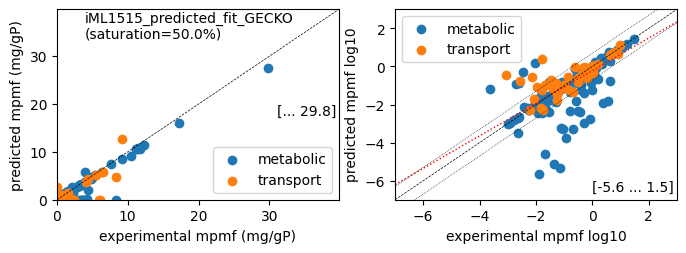

1 file(s) exported for "Load reaction data" into Escher maps


In [8]:
# Optimize model using cobrapy and analyze results
pred_results = {}
for cond, medium in conditions.items():
    with ecm as model:
                
        model.medium = medium 
        solution = model.optimize()
        if solution.status == 'optimal':
            gr = solution.objective_value
            pred_results[cond] = solution
            print(f'{cond:25s}: pred gr: {gr:.3f} h-1 vs. exp {exp_grs[cond]:.3f}, '
                  f'diff: {gr - exp_grs[cond]:6.3f}')
        else:    
            print(f'{cond} ended with status {solution.status}')
            
er = EcmResults(eo, pred_results, df_mpmf)
df_fluxes = er.collect_fluxes()
df_net_fluxes = er.collect_fluxes(net=True)
df_proteins = er.collect_protein_results()
er.plot_grs(exp_grs, highlight=reference_cond)
print(f'Protein mass fractions:')
er.report_proteomics_correlation(scale='lin')
er.report_proteomics_correlation(scale='log')
print()
er.report_protein_levels(reference_cond)
er.plot_proteins(reference_cond)  
er.save_to_escher(df_net_fluxes[reference_cond], os.path.join('escher', target_model))

In [9]:
# analyze reactions selected fluxes
rids = ['G6PDH2r', 'EDA', 'PGI', 'PFK', 'FBA', 'TPI', 'GAPD', 'PGK', 'PGM', 'ENO', 'PYK']
for rid in rids:
    print(f'{rid:15s}: {df_net_fluxes.at[rid, reference_cond]:8.3f} mmol/gDWh [{df_net_fluxes.at[rid, "gpr"]}]')

G6PDH2r        :    3.516 mmol/gDWh [b1852]
EDA            :    0.000 mmol/gDWh [b1850]
PGI            :    3.749 mmol/gDWh [b4025]
PFK            :    5.560 mmol/gDWh [b1723 or b3916]
FBA            :    5.560 mmol/gDWh [b2097 or b2925]
TPI            :    5.473 mmol/gDWh [b3919]
GAPD           :   11.884 mmol/gDWh [b1779]
PGK            :  -11.884 mmol/gDWh [b2926]
PGM            :  -10.831 mmol/gDWh [b0755 or b3612]
ENO            :   10.831 mmol/gDWh [b2779]
PYK            :    3.057 mmol/gDWh [b1676 or b1854]


## Step 5 – GECKO model limitations

The optimization results of the final GECKO model have been obtained, thus allowing for the discussion of some of the limitations of GECKO modeling. The cases in which GECKO does not predict protein usage for proteins that have been measured at high concentrations will be discussed, as well as the suggestion that proteomics measurements have a slight bias towards cytosolic proteins and that small integral proteins are not measured correctly, which impacts correlation of protein concentrations. While the AI-predicted turnover numbers should approximate the in vitro values, we will examine situations where there are substantial discrepancies. Additionally, we will analyze the impact of automated fitting to the AI-predictions.


### 5.1 inability to predict protein usage

The GECKO model's inability to predict proteins that have been measured at high concentrations prompts the following inquiry:

b0197/metQ and b3460/livJ are proteins associated with transporters, which are measured at relatively high concentrations. These proteins are utilized in methionine and branched amino acid uptake systems (ABC transporters) and function as periplasmic binding proteins. Given the nutrient conditions lacking amino acids, these transporters do not carry flux, and the related proteins are part of the inactive proteome. However, the cells utilized in the proteomics experiment expressed these proteins at high quantities, suggesting either constitutive expression due to cells evolving under rich conditions or in anticipation of such conditions.

The b4015/aceA and b0605/ahpC genes encode metabolic proteins, which are measured at high concentrations; however, these proteins are not utilized by the model. b4015/aceA catalyzes the isocitrate lyase reaction (ICL) in the glyoxylate cycle. In the previous tutorial, we manually adjusted turnover values in the TCA cycle to generate flux through ICL. During automated fitting, this flux was switched off again, indicating the need for another manual adjustment. b0605/ahpC is a component of alkyl hydroperoxide reductase, which protects against oxidative stress. In the GECKO model, the protein is required to catalyze the NADH peroxidase reaction, which is inactive in the model.

In [10]:
# transport related proteins measured but not predicted
for gene, pred in df_proteins[reference_cond].to_dict().items():
    if gene in df_mpmf.index and gene in tx_genes:
        exp = df_mpmf.at[gene, reference_cond]
        if exp > 5 and pred == 0.0:
            description = df_proteins.at[gene, 'description']
            gname = df_proteins.at[gene, 'gene_name']
            rank = df_mpmf.at[gene, 'rank']
            print(f'{gene} pred {pred:8.4f} vs. {exp:8.4f} (rank {rank:2d}); {gname}: {description}')

b3460 pred   0.0000 vs.   6.1215 (rank 24); livJ: Leu/Ile/Val-binding protein
b0197 pred   0.0000 vs.   5.9980 (rank 38); metQ: D-methionine-binding lipoprotein metQ


In [11]:
# metabolic proteins measured but not predicted
for gene, pred in df_proteins[reference_cond].to_dict().items():
    if gene in df_mpmf.index and gene in metab_genes:
        exp = df_mpmf.at[gene, reference_cond]
        if (exp < 1 and pred > 5) or (exp > 5 and pred < 1):
            description = df_proteins.at[gene, 'description']
            gname = df_proteins.at[gene, 'gene_name']
            rank = df_mpmf.at[gene, 'rank']
            print(f'{gene} pred {pred:8.4f} vs. {exp:8.4f} (rank {rank:2d}); {gname}: {description}')

b0605 pred   0.0000 vs.   8.2787 (rank 15); ahpC: Alkyl hydroperoxide reductase subunit C


### 5.2 biased proteomics

A subsequent focus will be placed on protein concentrations related to transporters that have higher predicted than measured levels (red dots above the diagonal in the log10 correlation plot). Four proteins have predictions that are 20 times higher than measurements, and it is expected that automatic fitting would balance this out. The four proteins of interest, b3737/atpE, b2278/nuoL, b2276/nuoN, and b0430/cyoC, are components of larger enzymatic complexes that exhibit a fixed protein composition in the GECKO model. Consequently, they cannot be adjusted independently from the other proteins within the complex. It is hypothesized that the proteins may not have been accurately measured in the proteomics analysis due to their shared characteristic of being integral membrane proteins. 

The cytochrome bo3 ubiquinol:oxygen oxidoreductase complex, composed of four proteins expressed from the operon cyoABCD, serves as an example. The GECKO model predicts a protein requirement of 11.1 nmol/gP for the transporter and each of the four transporter components. However, the proteomics experiment yielded protein copy numbers of 0.1, 0.9, 6.5, and 17.9 nmol/gP. The low quantities of b0430/cycC and b0429/cyoD, which are small membrane proteins, may have led to their inaccurate quantification during the proteomics measurement.

In [12]:
# transport proteins with overpredicted concentration
for gene, pred in df_proteins[reference_cond].to_dict().items():
    if gene in df_mpmf.index and (gene in tx_genes):
        exp = df_mpmf.at[gene, reference_cond]
        if exp > 0 and pred/exp > 20:
            description = df_proteins.at[gene, 'description'][:50]
            gname = df_proteins.at[gene, 'gene_name']
            print(f'{gene} pred {pred:8.4f} vs. {exp:8.4f}; {gname}: {description}, {pred/exp:.2f}')

b3737 pred   2.5617 vs.   0.0161; atpE: ATP synthase subunit c, 159.35
b2278 pred   0.3739 vs.   0.0008; nuoL: NADH-quinone oxidoreductase subunit L, 442.83
b2276 pred   0.2929 vs.   0.0071; nuoN: NADH-quinone oxidoreductase subunit N, 41.17
b0430 pred   0.1640 vs.   0.0028; cyoC: Cytochrome o ubiquinol oxidase subunit 3, 59.29


In [13]:
# check cytochrome bo3 ubiquinol:oxygen oxidoreductase complex
for gene in ['b0432', 'b0431', 'b0430', 'b0429']:
    pred = df_proteins.at[gene, reference_cond]
    exp = df_mpmf.at[gene, reference_cond]
    mw_da = df_mpmf.at[gene, 'mw_Da']
    name = df_mpmf.at[gene, 'gene_name']
    print(f'{gene}/{name:4s} ({mw_da/1000.0:.1f} kDa): '
          f'pred {pred:.3f} mg/gP ({pred/mw_da*1e6:.1f} nmol/gP); '
          f'exp {exp:.3f} mg/gP ({exp/mw_da*1e6:5.1f} nmol/gP)')

b0432/cyoA (34.9 kDa): pred 0.253 mg/gP (7.3 nmol/gP); exp 0.623 mg/gP ( 17.9 nmol/gP)
b0431/cyoB (74.3 kDa): pred 0.539 mg/gP (7.3 nmol/gP); exp 0.485 mg/gP (  6.5 nmol/gP)
b0430/cyoC (22.6 kDa): pred 0.164 mg/gP (7.3 nmol/gP); exp 0.003 mg/gP (  0.1 nmol/gP)
b0429/cyoD (12.0 kDa): pred 0.087 mg/gP (7.3 nmol/gP); exp 0.011 mg/gP (  0.9 nmol/gP)


### 5.3 large difference predicted to fitted turnover numbers

Assuming that the AI-predicted turnover numbers are close to the apparent in vitro turnover numbers, which are required for the GECKO model formulation, it can be expected that all of the turnover numbers should have been fitted, given our maximum scaling factor of 100. However, 24 turnover numbers exceeded that scaling factor and consequently were not adjusted. 

An analysis of the corresponding reactions indicates that, in most cases (21 out of 24), the fitted turnover numbers would be considerably lower than the AI-predicted values, resulting in proteins being predicted at a significantly lower level than measured. This discrepancy can be attributed to one or more of the following reasons: Firstly, the AI-predicted turnover number is, in fact, too high, which can be verified by comparing with experimental values derived from databases and/or literature. Secondly, the model may predict insufficient flux through the reaction, potentially due to the model's preference for an alternative pathway. Thirdly, the cell may require the protein for tasks not included in the model, such as repair or housekeeping. Fourthly, the gene may be constitutively expressed, thus not directly linked to reaction fluxes, as observed in the expression of certain periplasmic binding proteins. Finally, a portion of the cellular protein may be inactive due to regulatory mechanisms.

Additionally, there are three cases where the AI-predicted turnover numbers are lower than the fitting to proteomics data suggests, and again, different causes can be identified. Firstly, proteomics may be biased to specific types of proteins, integral membrane proteins may be more difficult to isolate and measure correctly compared to soluble proteins. Secondly, the model predicts high flux through a reaction, while the cell uses another pathway. Thirdly, the AI-predicted turnover values are too high.


An illustration of proteomics failing to adequately measure a specific protein is the gene product of b0175/cdsA, an integral membrane protein. The AI-predicted turnover number for b0175/cdsA was 1.65 $s^{-1}$, which is well within the measured range of turnover numbers for CdsA (see BRENDA). The protein mass fraction of CdsA is comparatively low (0.009 mg/gP), and its copy number is significantly lower compared to neighboring proteins in the pathway, indicating that not all copies of b0175/cdsA were measured.

An illustration of the potential overestimation of the AI-predicted turnover numbers is evident in the synthesis of iron-sulfur clusters utilizing b2528/iscA or b2530/iscS. While the AI-predicted values are within the range of 15 $s^{-1}$, the proteomics data fitting suggests turnover numbers are three orders of magnitude lower. The turnover number for b2530/iscS has been measured at 0.202 $s^{-1}$  (Dunkle et al., 2019), which is more aligned with the proteomics-fitted value. The protein mass fraction for IscS, as measured, is relatively high (4.208 mg/gP). IscS has been shown to be required for Fe-S cluster repair and DNA housekeeping, which are not reflected in the GECKO model. 

Increasing the maximum scaling factor beyond 100.0 could improve the protein correlation. Setting the `max_scale_factor` to ‘None’ would result in unlimited scaling. However, it is important to note that limiting the maximum scaling provides a greater degree of control over the parametrization of the model and the potential for investigating and addressing inconsistencies.

In [14]:
# kcats not fitted due to exceeding factor (max_scale_factor set to 100 during auto-fit)
not_scaled = []
for data in exceeding_max_scale.values():
    sub_rid = data['iso_rid']
    fitted_kcat = data['orig_kcat'] * data['factor']
    gpr = eo.rdata[sub_rid]['gpr'] 
    react_str = eo.rdata[sub_rid]['reaction_str']
    not_scaled.append([sub_rid, data['orig_kcat'], fitted_kcat, data['factor'], react_str, gpr])
cols = ['sub_rid', 'orig_kcat', 'fitted_kcat', 'factor', 'reaction_string', 'genes']    
df_not_scaled = pd.DataFrame(not_scaled, columns=cols).set_index('sub_rid')
n_higher_kcat = len(df_not_scaled[df_not_scaled["factor"] > 1.0])
n_genes = len(df_not_scaled['genes'].unique())
print(f'{len(df_not_scaled)} kcat values exceed max scaling, concerning {n_genes} different gene products')
print(f'({n_higher_kcat} kcat values would be much higher, {len(df_not_scaled)- n_higher_kcat} much lower)')
df_not_scaled[df_not_scaled["factor"] > 1.0]

24 kcat values exceed max scaling, concerning 18 different gene products
(3 kcat values would be much higher, 21 much lower)


,orig_kcat,fitted_kcat,factor,reaction_string,genes
sub_rid,,,,,
ORPT_REV,8.66,1403.143135,162.025766,orot_c + prpp_c => orot5p_c + ppi_c,b3642
DASYN160,1.65,297.703107,180.426128,ctp_c + h_c + pa160_c => cdpdhdecg_c + ppi_c,b0175
DASYN161,1.65,297.703107,180.426128,ctp_c + h_c + pa161_c => cdpdhdec9eg_c + ppi_c,b0175


In [15]:
# enzymes in the CDP-diacylglycerol biosynthesis pathway suggest issues with proteomics
for gene in ['b0175',  'b2585', 'b4160', 'b0914']:
    pred = df_proteins.at[gene, reference_cond]
    row = df_mpmf.loc[gene]
    exp = row[reference_cond]
    mw_da = row["mw_Da"]
    print(f'{gene} {row["gene_name"]:4s} ({mw_da/1000.0:.1f} kDa): '
          f'pred {pred:.3f} mg/gP ({pred/mw_da*1e6:5.2f} nmol/gP); '
          f'exp {exp:.3f} mg/gP ({exp/mw_da*1e6:5.2f} nmol/gP)')

b0175 cdsA (31.4 kDa): pred 1.583 mg/gP (50.40 nmol/gP); exp 0.009 mg/gP ( 0.30 nmol/gP)
b2585 pssA (52.8 kDa): pred 0.099 mg/gP ( 1.87 nmol/gP); exp 0.107 mg/gP ( 2.02 nmol/gP)
b4160 psd  (35.9 kDa): pred 0.368 mg/gP (10.26 nmol/gP); exp 0.397 mg/gP (11.06 nmol/gP)
b0914 msbA (64.4 kDa): pred 0.062 mg/gP ( 0.96 nmol/gP); exp 0.067 mg/gP ( 1.03 nmol/gP)


In [16]:
# enzymes catalyzing Fe-S complexes suggest lowering the kcat value
df_not_scaled[df_not_scaled["genes"].str.contains('b25')]

,orig_kcat,fitted_kcat,factor,reaction_string,genes
sub_rid,,,,,
ICYSDS,15.24,0.014410,0.000946,cys__L_c + iscs_c => ala__L_c + iscssh_c,b2530
I2FE2SS,15.24,0.014410,0.000946,fadh2_c + 2.0 fe2_c + 2.0 iscssh_c + iscu_c =>...,b2530
I2FE2ST,11.34,0.018765,0.001655,4.0 h_c + iscu_2fe2s_c => 2fe2s_c + iscu_c,b2528
I2FE2SS2,15.24,0.014410,0.000946,fadh2_c + 2.0 fe2_c + 2.0 iscssh_c + iscu_2fe2...,b2530
I4FE4ST,11.34,0.018765,0.001655,4.0 h_c + iscu_4fe4s_c => 4fe4s_c + iscu_c,b2528
I2FE2SR,15.24,0.014410,0.000946,2fe1s_c + iscssh_c + iscu_c => 4.0 h_c + iscs_...,b2530


### 5.4 predicted vs. fitted turnover numbers

Less than 25% of all turnover numbers of metabolic reactions were fitted to proteomics data (542 out of 2349 kcat values). Although all turnover numbers undergo slight recalibration to attain target enzyme saturation, proteomics analysis is only applicable to reactions that facilitate traffic. The application of proteomics to these reactions has been observed to augment variance in turnover numbers.

In [17]:
# collect original vs. auto-fitted
import numpy as np

df_orig_kcats = load_parameter_file(os.path.join('data', f'{baseline_model}_kcats.xlsx'))['kcats']
df_fitted_kcats = load_parameter_file(os.path.join('data', f'{target_model}_kcats.xlsx'))['kcats']

metab_kcats = []
for key, row in df_orig_kcats.iterrows():
    if row['info_type'] == 'metabolic':
        metab_kcats.append([row['kcat_per_s'], df_fitted_kcats.at[key, 'kcat_per_s']])
metab_kcats = np.array(metab_kcats)
log_x = np.log10(metab_kcats[:,0])
log_y = np.log10(metab_kcats[:,1])
log_delta = np.log10(10.0)

scale_factors = metab_kcats[:,1]/metab_kcats[:,0]
fitted_factors = scale_factors[scale_factors != 1.0]
fitted_kcats = metab_kcats[scale_factors != 1.0, :]
print(f'{len(metab_kcats):4d} metabolic sub-reactions catalyzed by enzymes')
print(f'     mean TurNuP kcats {np.mean(metab_kcats[:,0]):.1f} s-1, '
      f'fitted kcats: { np.mean(metab_kcats[:,1]):.1f} s-1')
print(f'{len(fitted_factors):4d} kcat values fitted with mean factor {np.mean(fitted_factors):.2f}')
print(f'     mean TurNuP kcats {np.mean(fitted_kcats[:,0]):.1f} s-1 (std: {np.std(fitted_kcats[:,0]):.1f}), '
      f'fitted kcats: { np.mean(fitted_kcats[:,1]):.1f} s-1 (std: {np.std(fitted_kcats[:,1]):.1f})')

1 table(s) with parameters loaded from data/iML1515_manual_adjust_GECKO_kcats.xlsx (Thu Feb 12 15:21:28 2026)
1 table(s) with parameters loaded from data/iML1515_predicted_fit_GECKO_kcats.xlsx (Thu Feb 12 15:25:00 2026)
2349 metabolic sub-reactions catalyzed by enzymes
     mean TurNuP kcats 32.1 s-1, fitted kcats: 34.5 s-1
 550 kcat values fitted with mean factor 3.58
     mean TurNuP kcats 52.4 s-1 (std: 456.8), fitted kcats: 62.5 s-1 (std: 245.0)


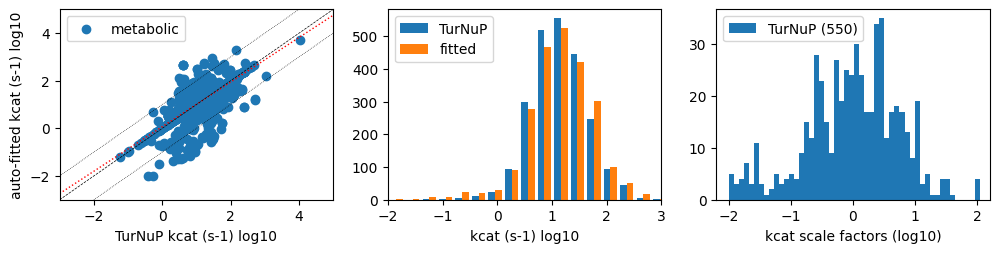

In [18]:
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt

marker2 = mpl.markers.MarkerStyle('o', fillstyle='full')

fig, axs = plt.subplots(1, 3, figsize=(12.0, 4.0 * .618), squeeze=False)
for gcol in [0, 1, 2]:
    ax = axs[0, gcol]
    if gcol == 0: 
        xy_range = (-3.0, 5.0)
        #log_x, log_y = er.get_log10_xy(all_kcats)
        ax.scatter(log_x, log_y, marker=marker2, label='metabolic')
        slope, intercept, rvalue, pvalue, stderr = scipy.stats.linregress(log_x, log_y)
        ax.plot((xy_range[0], xy_range[1]),
                (slope * xy_range[0] + intercept, slope * xy_range[1] + intercept), 'r:', lw=1)
        ax.plot((xy_range[0] + log_delta, xy_range[1]), (xy_range[0], xy_range[1] - log_delta), 'k:', lw=0.5)
        ax.plot((xy_range[0], xy_range[1] - log_delta), (xy_range[0] + log_delta, xy_range[1]), 'k:', lw=0.5)

        ax.set_xlabel(r'TurNuP kcat (s-1) log10')
        ax.set_ylabel(r'auto-fitted kcat (s-1) log10')
        ax.legend(loc='upper left')
        ax.set(xlim=xy_range, ylim=xy_range)
        ax.plot(xy_range, xy_range, 'k--', lw=0.5)
    elif gcol == 1:
        ax.hist((log_x, log_y), bins=20, linewidth=0.5, label=['TurNuP', 'fitted'])
        ax.set_xlabel(r'kcat (s-1) log10')
        ax.legend(loc='upper left')
        ax.set(xlim=(-2, 3))
    elif gcol == 2:
        ax.hist(np.log10(fitted_factors), bins=50, linewidth=0.5, label=f'TurNuP ({len(fitted_factors)})')
        ax.set_xlabel(r'kcat scale factors (log10)')
        ax.legend(loc='upper left')
        ax.set(xlim=(-2.2, 2.2))
plt.show()

## (Optional) Track progress

In [19]:
import scipy
import numpy as np

number = 5
xy = np.array([[df_mpmf.at[gene, reference_cond], df_proteins.at[gene, reference_cond]] 
                for gene in df_proteins.index if gene in df_mpmf.index])
log10_x, log10_y = er.get_log10_xy(xy)
lin_pearson_r, _ = scipy.stats.pearsonr(xy[:, 0], xy[:, 1])
log_pearson_r, _ = scipy.stats.pearsonr(log10_x, log10_y)

predictions = load_parameter_file('protein_predictions.xlsx')
data = [[number, target_model, lin_pearson_r**2,log_pearson_r**2, len(xy), len(log10_x)]]
cols = ['No', 'model', 'lin r2', 'log r2', 'lin proteins', 'log proteins']
df = pd.DataFrame(data, columns=cols).set_index('No')
if number in predictions[reference_cond].index:
    predictions[reference_cond].drop(index=number, inplace=True)
predictions[reference_cond] = pd.concat((predictions[reference_cond], df)).sort_index()
write_parameter_file('protein_predictions.xlsx', predictions)
predictions[reference_cond]

1 table(s) with parameters loaded from protein_predictions.xlsx (Thu Feb 12 15:22:11 2026)
1 table(s) with parameters written to protein_predictions.xlsx


,model,lin r2,log r2,lin proteins,log proteins
No,,,,,
1,iML1515_default_GECKO,0.033244,0.190225,1018,299
2,iML1515_modified_GECKO,0.135981,0.201613,999,322
3,iML1515_predicted_GECKO,0.078803,0.268769,999,308
4,iML1515_manual_adjust_GECKO,0.205413,0.333470,999,308
5,iML1515_predicted_fit_GECKO,0.869850,0.549757,999,313


## Closing remarks

While artificial intelligence (AI)-predicted turnover numbers might serve as a valuable starting point, manual adjustments and automatic fitting of turnover numbers to proteomics data hold significant potential for enhancing the prediction of protein concentrations under both reference conditions and other nutrient conditions. This enhancement can be attributed to the fact that the AI-prediction model is based on experimentally derived turnover numbers that are scarce, noisy, and acquired by non-standardized methods. In contrast, quantitative proteomics is a standardized, high-throughput method with almost complete coverage of the proteome.

Nevertheless, there appears to be a potential for further improvements, particularly with regard to different reactions and pathways. These improvements could involve additional cycles of manual parameter adjustments followed by automatic fitting to proteomics. With varying nutrient conditions, different areas of the metabolic network could be explored and subjected to manual adjustment and automatic fitting workflows.

However, achieving perfect correlation between predicted and measured protein concentrations will not be feasible for a complex metabolic network. This discrepancy arises from the modeling of enzymes with integer-based stoichiometry of participating proteins, while the measured proteins exhibit variable copy number ratios. Additionally, proteins may be components of different enzyme complexes, precluding their independent adjustment.  

The final GECKO model of iML1515 was created through a gradual improvement of model parameters, commencing with an initial GECKO model that employed default parametrization. The configuration data of this final GECKO model will serve as a baseline for the construction of a resource balance model (RBA) of iML1515, as well as for the creation of thermodynamics constraint TGECKO and TRBA models.

---
---
## (Alternative) gurobipy – automatic fitting to proteomics data

In [20]:
# Load GECKO model and optimize for reference condition using gurobipy
fname = os.path.join('SBML_models', f'{baseline_model}.xml')
eo = EcmOptimization(fname)
total_protein = eo.get_variable_bounds('V_PC_total')['V_PC_total'][1]
sigma = eo.avg_enz_saturation
print(f'total modeled protein: {total_protein:.2f} mg/gDW, enzyme saturation level: {sigma}')

# Calculate GECKO solution for given condition
eo.medium = conditions[reference_cond]
solution = eo.optimize()
gr = solution.objective_value
print(f'{reference_cond}: growth rate {gr:.3f} h-1 ({solution.status})')

SBML model loaded by sbmlxdf: SBML_models/iML1515_manual_adjust_GECKO.xml (Thu Feb 12 15:21:50 2026)
LP Model of iML1515_GECKO
7343 variables, 3372 constraints, 28438 non-zero matrix coefficients
total modeled protein: 306.59 mg/gDW, enzyme saturation level: 0.56
Glucose: growth rate 0.661 h-1 (optimal)


In [21]:
# Select proteins for the automatic fit
excluded_loci = {'b0929', 'b2215', 'b1377', 'b0241', 'b2400'}
measured_mpmfs = {} 
excluded_mpmfs = {} 
for locus, mpmf in df_mpmf[reference_cond].items():
    if locus in eo.locus2uid:
        if locus not in excluded_loci:
            measured_mpmfs[locus] = mpmf        
        else:
            excluded_mpmfs[locus] = mpmf
print(f'{len(measured_mpmfs):4d} proteins measured with total of {sum(measured_mpmfs.values()):5.1f} mg/gP')
print(f'{len(excluded_mpmfs):4d} proteins excluded with total of {sum(excluded_mpmfs.values()):5.1f} mg/gP')

# Automatically fit kcat values to proteomics
target_enz_sat = 0.5
orig_kcats_fname = os.path.join('data', f'{baseline_model}_kcats.xlsx')
fitted_kcats_fname = os.path.join('data', f'{target_model}_kcats.xlsx')

gfk = GeckoFitKcats(eo, orig_kcats_fname)
tot_fitted_mpmf = gfk.process_data(solution.fluxes, measured_mpmfs)
exceeding_max_scale = gfk.update_kcats(fitted_kcats_fname, target_sat=target_enz_sat, max_scale_factor=100.0)

# Create updated XBA parameter file
xba_params = load_parameter_file(os.path.join('data', f'{baseline_model}_xba_parameters.xlsx'))
xba_params['general'].at['kcats_fname', 'value'] = os.path.join('data', f'{target_model}_kcats.xlsx')
write_parameter_file(os.path.join('data', f'{target_model}_xba_parameters.xlsx'), xba_params)

# Create updated ECM parameter file
ecm_params = load_parameter_file(os.path.join('data', f'{baseline_model}_ecm_parameters.xlsx'),['general'])
fitted_pmf = (tot_fitted_mpmf + sum(excluded_mpmfs.values()))/1000.0
ecm_params['general'].at['pm2totpm_val_or_paxdb', 'value'] = fitted_pmf
ecm_params['general'].at['avg_enz_sat', 'value'] = target_enz_sat
write_parameter_file(os.path.join('data', f'{target_model}_ecm_parameters.xlsx'), ecm_params)

 996 proteins measured with total of 497.8 mg/gP
   3 proteins excluded with total of  16.6 mg/gP
5357 enzyme catalyzed iso-reactions (2221 reactions, 1494 proteins)
 394 active catalyzed reactions with total protein of 537.9 mg/gP (based on GECKO simulation)
 417 proteins potentially involved in active reactions
 352 active catalyzed reactions using total protein of 356.7 mg/gP (based on proteomics)
  42 active catalyzed reactions have no measured proteins provided
5357 original kcat records loaded from data/iML1515_manual_adjust_GECKO_kcats.xlsx
 584 kcat records fitted. Scale factor range [0.0101105, 110.0]
  24 (net) reactions would exceed the maximum scaling factor of 100.0 and will not be scaled
fitted kcats exported to data/iML1515_predicted_fit_GECKO_kcats.xlsx
3 table(s) with parameters loaded from data/iML1515_manual_adjust_GECKO_xba_parameters.xlsx (Thu Feb 12 15:21:28 2026)
3 table(s) with parameters written to data/iML1515_predicted_fit_GECKO_xba_parameters.xlsx
1 table(s)

In [22]:
# Load model using gurobipy
fname = os.path.join('SBML_models', f'{target_model}.xml')
eo = EcmOptimization(fname)
total_protein = eo.get_variable_bounds('V_PC_total')['V_PC_total'][1]
sigma = eo.avg_enz_saturation
all_genes = set(eo.m_dict['fbcGeneProducts']['label'].values)
tx_genes, metab_genes = eo.get_tx_metab_genes()
print(f'total modeled protein: {total_protein:.2f} mg/gDW, average saturation level: {sigma}')
print(f'{len(all_genes)} genes: ({len(tx_genes)}) transporter, ({len(metab_genes)}) metabolic')

SBML model loaded by sbmlxdf: SBML_models/iML1515_predicted_fit_GECKO.xml (Thu Feb 12 15:25:22 2026)
LP Model of iML1515_GECKO
7343 variables, 3372 constraints, 28438 non-zero matrix coefficients
total modeled protein: 212.80 mg/gDW, average saturation level: 0.5
1494 genes: (492) transporter, (1002) metabolic


Acetate                  : pred gr: 0.341 h-1 vs. exp 0.290, diff:  0.051
Glycerol                 : pred gr: 0.540 h-1 vs. exp 0.470, diff:  0.070
Fructose                 : pred gr: 0.544 h-1 vs. exp 0.540, diff:  0.004
L-Malate                 : pred gr: 0.526 h-1 vs. exp 0.550, diff: -0.024
Glucose                  : pred gr: 0.613 h-1 vs. exp 0.660, diff: -0.047
Glucose 6-Phosphate      : pred gr: 0.608 h-1 vs. exp 0.780, diff: -0.172


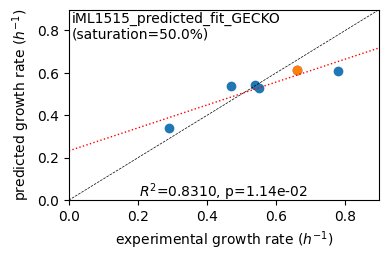

Protein mass fractions:
Acetate                  : r² = 0.2511, p = 1.25e-64 ( 999 proteins lin scale)
Glycerol                 : r² = 0.2292, p = 2.26e-58 ( 999 proteins lin scale)
Fructose                 : r² = 0.6175, p = 2.71e-210 ( 999 proteins lin scale)
Glucose                  : r² = 0.8699, p = 0.00e+00 ( 999 proteins lin scale)
Acetate                  : r² = 0.4562, p = 2.21e-42 ( 308 proteins log scale)
Glycerol                 : r² = 0.4894, p = 5.06e-47 ( 311 proteins log scale)
Fructose                 : r² = 0.5298, p = 4.40e-51 ( 302 proteins log scale)
Glucose                  : r² = 0.5498, p = 7.85e-56 ( 313 proteins log scale)

condition: Glucose
1494 proteins in model with total predicted mass fraction of 373.3 mg/gP
      999 have been measured with mpmf of  514.4 mg/gP vs. 331.8 mg/gP predicted
           762 metabolic proteins measured 414.0 mg/gP vs. 280.5 mg/gP predicted
           237 transport proteins measured 100.4 mg/gP vs.  51.3 mg/gP predicted
      4

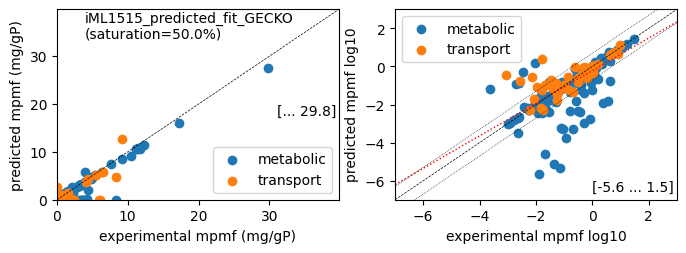

1 file(s) exported for "Load reaction data" into Escher maps


In [23]:
# Optimize model using gurobipy and analyze results
pred_results = {}
for cond, medium in conditions.items():
    eo.medium = medium
    solution = eo.optimize()

    if solution.status == 'optimal':
        pred_results[cond] = solution
        gr = solution.objective_value
        print(f'{cond:25s}: pred gr: {gr:.3f} h-1 vs. exp {exp_grs[cond]:.3f}, diff: {gr - exp_grs[cond]:6.3f}')
    else:    
        print(f'{cond} ended with status {solution.status}')
        
# Analyze results
er = EcmResults(eo, pred_results, df_mpmf)
df_fluxes = er.collect_fluxes()
df_net_fluxes = er.collect_fluxes(net=True)
df_proteins = er.collect_protein_results()
er.plot_grs(exp_grs, highlight='Glucose')

print(f'Protein mass fractions:')
er.report_proteomics_correlation(scale='lin')
er.report_proteomics_correlation(scale='log')
print()
er.report_protein_levels('Glucose')
er.plot_proteins('Glucose', plot_fname=os.path.join('plots', f'{target_model}_proteins_Glucose.pdf'))  
er.save_to_escher(df_net_fluxes['Glucose'], os.path.join('escher', target_model))

---
---
## References

- Domenzain, I., Sánchez, B., Anton, M., Kerkhoven, E. J., Millán-Oropeza, A., Henry, C., Siewers, V., Morrissey, J. P., Sonnenschein, N., & Nielsen, J. (2022). Reconstruction of a catalogue of genome-scale metabolic models with enzymatic constraints using GECKO 2.0. Nat Commun, 13(1), 3766. https://doi.org/10.1038/s41467-022-31421-1 
- Dunkle, J. A., Bruno, M. R., Outten, F. W., & Frantom, P. A. (2019). Structural Evidence for Dimer-Interface-Driven Regulation of the Type II Cysteine Desulfurase, SufS. Biochemistry, 58(6), 687-696. https://doi.org/10.1021/acs.biochem.8b01122 
- Wendering, P., Arend, M., Razaghi-Moghadam, Z., & Nikoloski, Z. (2023). Data integration across conditions improves turnover number estimates and metabolic predictions. Nature Communications, 14(1), 1485. https://doi.org/10.1038/s41467-023-37151-2 

